# Forest Fire Detection with transfer learning using VGG19

First we import all the necessary libraries.

In [1]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers
from keras.models import load_model
from keras.applications import VGG19
from keras import layers
from keras import Model
import matplotlib.pyplot as plt
%matplotlib inline

## Getting the data

Now we declare the path for our training and testing data. In this case, we are loading from our current directory, assuming the data is in a folder in this same level called data/

In [2]:
train_dir = "data/Training"
test_dir = "data/Test"

VGG_SIZE = 224

Now we create the train and test data generators. For the train data generator we apply data augmentation by providing a width and height shift range, as well as a zoom range and horizontal split. We also specify that we want 20% of the training data as validation set.

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                zoom_range=0.1,
                                horizontal_flip=True,
                                validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

We now create the train, validation and test generators by specifying the directories.

In [4]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                target_size=(VGG_SIZE, VGG_SIZE), 
                                                color_mode='rgb',
                                                batch_size=20,
                                                subset='training',
                                                class_mode='binary')

val_generator = train_datagen.flow_from_directory(train_dir,
                                                target_size=(VGG_SIZE, VGG_SIZE), 
                                                color_mode='rgb',
                                                batch_size=20,
                                                subset='validation',
                                                class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                target_size=(VGG_SIZE, VGG_SIZE),
                                                color_mode='rgb',
                                                batch_size=20,
                                                class_mode='binary')

Found 31517 images belonging to 2 classes.
Found 7878 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


## Creating the model

Now we first load the pre-trained VGG19 model from the keras library with the imagenet weights

In [5]:
transfer_model = VGG19(include_top=True,
                        weights="imagenet",
                        classes=1000)
input = transfer_model.inputs

We now add our own top layers, and specify that all, except our top layers are not trainable, basically freezing the weights

In [6]:
x = transfer_model.get_layer("block5_pool").output
x = layers.Flatten(name='flatten')(x)
x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(4096, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)

classifier = Model(input, output_layer)

for layer in classifier.layers[:-5]:
    layer.trainable = False

classifier.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

We now compile our classifier with binary crossentropy as loss function and Adam optimizer with 0.001 learning rate.

In [7]:
classifier.compile(loss="binary_crossentropy",
                optimizer=optimizers.Adam(lr=0.001),
                metrics=["accuracy"])

## Training the model

Now we train the model adding some callbacks for early stopping and to save the model every epoch.

In [8]:
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True),
    ModelCheckpoint(filepath='models/vgg19_model.h5', save_best_only=True, monitor='val_accuracy'),
]

history = classifier.fit(train_generator, 
                        epochs=5, 
                        batch_size=40,
                        validation_data=test_generator)

Epoch 1/5
1576/1576 [==============================] - 534s 335ms/step - loss: 0.7733 - accuracy: 0.9508 - val_loss: 2.7361 - val_accuracy: 0.6651
Epoch 2/5
1576/1576 [==============================] - 516s 327ms/step - loss: 0.0412 - accuracy: 0.9868 - val_loss: 1.2843 - val_accuracy: 0.7346
Epoch 3/5
1576/1576 [==============================] - 516s 328ms/step - loss: 0.0334 - accuracy: 0.9891 - val_loss: 2.7195 - val_accuracy: 0.7000
Epoch 4/5
 594/1576 [==========>...................] - ETA: 4:32 - loss: 0.0407 - accuracy: 0.9885

KeyboardInterrupt: 

We now graph the results of the training.

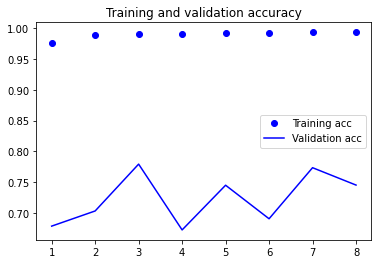

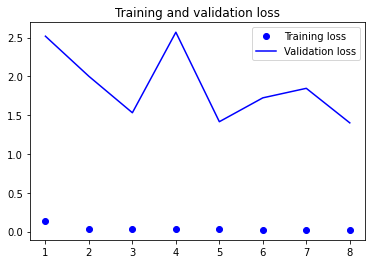

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

## Evaluating the model

Now we run the evaluation on the test set and see the result.

In [13]:
result = classifier.evaluate(test_generator)
print(f"Test loss: {result[0]}, Test accuracy: {result[1]}")

431/431 [==============================] - 82s 190ms/step - loss: 1.5786 - accuracy: 0.7660
Test loss: 1.5786386728286743, Test accuracy: 0.7660438418388367
